In [12]:
# convert jsonl to csv
import json
import pandas as pd

def jsonl_to_csv(jsonl_file, csv_file):
    data = []
    with open(jsonl_file, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    
    # lowercase the 'answer' column
    # df['answer'] = df['answer'].str.lower()
    df.to_csv(csv_file, index=False)
    
json_file = "/home/jnlp/minhnt/AdvML/results/dev_scene_graph/qwen3_vl_4b_dev_obj_detect.jsonl"
csv_file = "/home/jnlp/minhnt/AdvML/results/dev_scene_graph/qwen3_vl_4b_dev_obj_detect.csv"
jsonl_to_csv(json_file, csv_file)

In [11]:
# process dev data
import json
import pandas as pd

input_json_path = "/home/jnlp/minhnt/AdvML/results/dev_gen_x/qwen25-vl-3b-instruct-trl-sft_19k-2eps_genx.jsonl"
dev_labels_path = "/home/jnlp/minhnt/AdvML/custom_dataset/dev_split.csv"

with open(input_json_path, 'r') as f:
    data = [json.loads(line) for line in f]
input_df = pd.DataFrame(data)
dev_labels_df = pd.read_csv(dev_labels_path)    
input_df['answer'] = dev_labels_df['answer']

# extract explanation only
input_df['explanation'] = input_df['explanation'].apply(lambda x: x.split("Explanation: ")[-1].strip().replace("Explanation: ", ""))
input_df['explanation'] = input_df['explanation'].apply(lambda x: x.split("explanation: ")[-1].strip().replace("explanation: ", ""))
input_df['explanation'] = input_df['explanation'].apply(lambda x: x.capitalize())

out_path = input_json_path.replace(".jsonl", "_with_answers.csv")
input_df.to_csv(out_path, index=False)


In [9]:
# split <answer> and <explanation>
import json
import pandas as pd
lora_test_path = "/home/jnlp/minhnt/AdvML/results/dev_standard_prompt/qwen2_5_vl_3b_lora_dev_output.jsonl"

with open(lora_test_path, 'r') as f:
    lora_data = [json.loads(line) for line in f]
    
formated_results = []
    
for idx, item in enumerate(lora_data):
    answer = item["answer"].split(" ")[-1].strip().lower().replace(".", "")
    explanation = item["answer"].split("Explanation:")[-1].strip()
    
    formated_results.append({
        "id": idx,
        "answer": f"{answer}",
        "explanation": f"{explanation}"
    })
    
    # print(f"Q{idx}: {answer}, Explanation: {explanation}")
    # break
    
formated_df = pd.DataFrame(formated_results)
dev_tbd = pd.read_csv("/home/jnlp/minhnt/AdvML/results/dev_dl/tbd_nets.csv")
formated_df["answer"] = dev_tbd["answer"]
formated_df.to_csv(lora_test_path.replace(".jsonl", ".csv"), index=False)

In [16]:
import pandas as pd
import numpy as np
import json
import os
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def clean_text(text):
    punctuations = '''!()-[]{};:'"\.,<>/?@#$%^&*_~'''
    for p in punctuations:
        text = text.replace(p, "")
    text = text.lower()
    return text

class ParticipantVisibleError(Exception):
    # If you want an error message to be shown to participants, you must raise the error as a ParticipantVisibleError
    # All other errors will only be shown to the competition host. This helps prevent unintentional leakage of solution data.
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Compute the competition score by comparing predicted answers and explanations
    against the ground truth.

    The ID column specified by `row_id_column_name` is removed from both dataframes.
    For each row, the predicted answer is matched to the ground-truth answer using
    case-insensitive exact comparison. If the answer is correct, the BLEU score is
    computed between the predicted explanation and each reference explanation, and
    the highest BLEU value is kept. If the answer is incorrect, the BLEU score is 0.

    The final score is the mean BLEU score across all samples (including zeros).

    Parameters
    ----------
    solution : pd.DataFrame
        DataFrame with ground-truth `answer` and list-based `explanation` fields.
    submission : pd.DataFrame
        DataFrame with predicted `answer` and `explanation` fields.
    row_id_column_name : str
        Column name to remove before scoring.

    Returns
    -------
    float
        Mean conditional BLEU score across all samples.
    """
    # rewrite the eval_metrics function to use solution and submission dataframes
    del solution[row_id_column_name]
    # del submission[row_id_column_name]
    
    corrects = np.zeros(len(solution))
    sample_bleu = np.zeros(len(solution))

    assert len(solution) == len(submission), "Solution and submission must have the same number of rows."

    for i in range(len(solution)):
        sol_answer = solution.iloc[i]['answer']
        subm_answer = submission.iloc[i]['answer']
        sol_explanations = json.loads(solution.iloc[i]['explanation'].replace("'", '"'))
        subm_explanation = submission.iloc[i]['explanation']

        if str(sol_answer).strip().lower() == str(subm_answer).strip().lower():
            corrects[i] = 1
            # Compute BLEU score for explanations
            best_bleu = 0.0
            for sol_explanation in sol_explanations:
                reference = [clean_text(sol_explanation).split()]
                try:
                    candidate = clean_text(subm_explanation).split()
                except Exception as e:
                    print(subm_explanation)
                try:
                    curr_bleu = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
                    if curr_bleu > best_bleu:
                        best_bleu = curr_bleu
                except Exception as e:
                    print(f"Error: {e}")
                    print(f"Error computing BLEU score at index: {i}")
            sample_bleu[i] = best_bleu
        else:
            sample_bleu[i] = 0.0

    average_bleu = np.mean(sample_bleu)
    
    submission['gold_explanation'] = solution['explanation']
    submission['bleu'] = sample_bleu
    
    accuracy = np.mean(corrects)
    return accuracy, average_bleu, submission

def submission_postprocess(submission: pd.DataFrame) -> pd.DataFrame:
    # extract the first work as the answer
    def extract_answer_last(answer: str) -> str:
        return answer.strip().split(' ')[-1].lower().replace('.', '')
    
    def extract_answer_first(answer: str) -> str:
        return answer.strip().split('.')[0].lower()
    
    submission['answer'] = submission['answer'].apply(extract_answer_last)
    # submission['answer'] = submission['answer'].apply(extract_answer_first)
    return submission


def main():
    # Example usage
    submission_root = "/home/jnlp/minhnt/AdvML/results/"
    # submission_file = "dev_dl/tbd_nets.csv"
    submission_file = "dev_gen_x/internvl2_5_4b_sft_11k_genx_v2_with_answers.csv"
    submission_path = os.path.join(submission_root, submission_file)
    # submission_csv_data = pd.read_json(submission_path, lines=True)
    submission = pd.read_csv(os.path.join(submission_root, submission_file))
    
    solution = pd.read_csv("/home/jnlp/minhnt/AdvML/custom_dataset/dev_split.csv")
    # submission = pd.read_csv("submission.csv")
    # submission = submission_postprocess(submission_csv_data)
    # print(submission["answer"][0])
    
    row_id_column_name = "id"

    accuracy, avg_bleu, submission = score(solution, submission, row_id_column_name)
    
    out_file = submission_file.replace(".csv", "_scored.csv")
    submission.to_csv(os.path.join(submission_root, out_file), index=False)
    
    print(submission_file)
    print(f"Accuracy: {accuracy}")
    print(f"Average BLEU Score: {avg_bleu}")
    
if __name__ == "__main__":
    main()

<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_478937/2038205085.py:8: SyntaxWarning: invalid escape sequence '\.'
  punctuations = '''!()-[]{};:'"\.,<>/?@#$%^&*_~'''


dev_gen_x/internvl2_5_4b_sft_11k_genx_v2_with_answers.csv
Accuracy: 1.0
Average BLEU Score: 0.9048837506016938


In [14]:
import pandas as pd
path = "/home/jnlp/minhnt/AdvML/results/dev_gen_x/qwen25-vl-3b-instruct-trl-sft_19k-2eps_genx_with_answers_scored.csv"

df = pd.read_csv(path)
df = df.sort_values(by="bleu", ascending=True)
for index, row in df.iterrows():
    if row['bleu'] > 0.8:
        continue
    print(f"BLEU: {row['bleu']}")
    print(f"Predicted Explanation: {row['explanation']}")
    print(f"Gold Explanation: {row['gold_explanation']}")

BLEU: 0.0076963394393061
Predicted Explanation: There is a metallic sphere that is left of the red matte cylinder and there is a metallic ball that is in front of the small green metallic ball.
Gold Explanation: ['There are two metallic spheres.']
BLEU: 0.0203755456656678
Predicted Explanation: There are two small gray matte cubes and a small purple metal cylinder that have the same size as the purple metallic cylinder. there is also a small gray matte sphere. there is one small red metallic cylinder. there is one small gray matte cube. there is one small purple metal cylinder. there is one small gray matte sphere. there is one small red metallic cylinder. there is a small gray matte cube. there is a small purple metal cylinder. there is a small gray matte sphere. there is a small red metallic cylinder. there is a small gray matte cube. there is a small purple metal cylinder. there is a small gray matte sphere. there is a small red metallic cylinder. there is a small gray matte cube. t

In [ ]:
import pandas as pd
path = "/home/jnlp/minhnt/AdvML/results/dev_gen_x/internvl2_5_4b_sft_11k_genx_v2_with_answers_scored.csv"

df = pd.read_csv(path)
df = df.sort_values(by="bleu", ascending=True)
for index, row in df.iterrows():
    if row['bleu'] > 0.8:
        continue
    print(f"ID: {row['id']}, BLEU: {row['bleu']}")
    # print(f"Answer: {row['answer']}")
    print(f"Answer: {row['answer']}. Predicted Explanation: {row['explanation']}")
    print(f"Gold Explanation: {row['gold_explanation']}")

ID: 2939, BLEU: 0.0565001260405798
Answer: 2. Predicted Explanation: There are two rubber cubes.
Gold Explanation: ['There are a small green rubber cube and sphere.']
ID: 2451, BLEU: 0.0741944662736501
Answer: 3. Predicted Explanation: There are a tiny brown block and two tiny cyan cubes.
Gold Explanation: ['There are two tiny cubes and a tiny cylinder.']
ID: 4066, BLEU: 0.1082597837309053
Answer: brown. Predicted Explanation: There is a big brown matte cube that is behind the gray rubber cube.
Gold Explanation: ['The big matte cube behind a gray rubber cube is brown.', 'The big matte cube behind a gray rubber block is brown.']
ID: 179, BLEU: 0.1504843536148921
Answer: yes. Predicted Explanation: There is a tiny shiny cylinder that is left of the rubber cylinder and there is a shiny cylinder that is to the right of the brown cylinder.
Gold Explanation: ['The tiny cylinder to the left of a rubber cylinder is metal and the cylinder to the right of a brown cylinder is shiny.', 'The tiny c

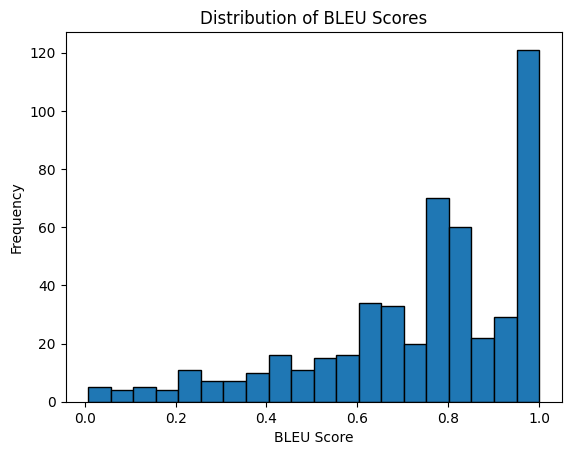

In [15]:
import matplotlib.pyplot as plt

bleu_scores = df['bleu'].values
plt.hist(bleu_scores, bins=20, edgecolor='black')
plt.title('Distribution of BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import pandas as pd
import regex as re
import ast

train_df = pd.read_csv("/home/jnlp/minhnt/AdvML/custom_dataset/train_labels.csv")
explanations = train_df['explanation']
patterns = ["which is", "that is"]
# for e in explanations:
#     e = ast.literal_eval(e)[0]
#     cnt = 0
#     for p in patterns:
#         cnt += len(re.findall(p, e.lower()))
#     if cnt > 1:
#         print(f"Explanation: {e}, Count: {cnt}")

Explanation: There are no tiny red balls which are on the right side of the tiny red cube that is right of the brown cylinder that is behind the small rubber sphere., Count: 2
Explanation: There is a big block which is in front of the cube that is behind the cube that is in front of the small purple metallic cube., Count: 3
Explanation: There is a green rubber sphere that is to the left of the red shiny sphere that is behind the purple cylinder., Count: 2
Explanation: There is a tiny yellow matte cylinder which is to the right of the small rubber cylinder that is left of the blue metal cylinder that is in front of the red matte sphere., Count: 3
Explanation: There is a tiny shiny cylinder which is in front of the big matte cylinder and there is a cyan matte cylinder which is behind the small green cylinder., Count: 2
Explanation: There are a large yellow metallic cylinder and sphere which are to the right of the big shiny cylinder that is in front of the yellow metal cylinder that is r

In [12]:
def major_vote(dfs):
    combined_answers = pd.concat([df['answer'] for df in dfs], axis=1)
    voted_answers = combined_answers.mode(axis=1)[0]
    return combined_answers, voted_answers

In [18]:
df1 = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test/qwen2_5_vl_3b_lora_test_output_hf.csv")
df2 = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test/internvl2_5_2b_dynamic_res_2nd_finetune_lora_test_wo_x.csv")
df3 = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test/internvl2_5_4b_dynamic_res_2nd_finetune_lora_test_wo_x.csv")
# df4 = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test/qwen2_5_vl_3b_lora_test_hf_run3.csv")
all, vote = major_vote([df1, df2, df3])
print(all)
compare_csv_files(df0, pd.DataFrame({'answer': vote}))
print(vote)

       answer    answer    answer
0       metal     metal     metal
1          no        no        no
2      rubber    rubber    rubber
3          no       yes        No
4    cylinder  cylinder  cylinder
..        ...       ...       ...
495       yes       yes       yes
496       yes        no    rubber
497    sphere  cylinder  cylinder
498  cylinder  cylinder  cylinder
499         1         1         1

[500 rows x 3 columns]
0         metal
1            no
2        rubber
3            No
4      cylinder
         ...   
495         yes
496          no
497    cylinder
498    cylinder
499           1
Name: 0, Length: 500, dtype: object


In [22]:
df1['answer'] = vote.apply(lambda x: x.lower())
print(df1)
df1.to_csv("/home/jnlp/minhnt/AdvML/results/test/qwen2_5_vl_3b_internvl_2b_4b_lora_test_major_vote.csv", index=False)

      id    answer                                        explanation
0      0     metal  There is a yellow metallic cylinder which is o...
1      1        no  There is a sphere which has the same shape as ...
2      2    rubber  There is a big matte block which is on the lef...
3      3        no  There is one big purple sphere and there are t...
4      4  cylinder  There is a small brown matte cylinder which ha...
..   ...       ...                                                ...
495  495       yes  The small metal ball and the small brown rubbe...
496  496        no  There is a tiny green rubber cylinder which is...
497  497  cylinder  There is a gray matte sphere which has the ide...
498  498  cylinder  There is a large cylinder that is behind the p...
499  499         1  There is a tiny brown rubber cylinder that has...

[500 rows x 3 columns]


In [26]:
# process ristretto results
df = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test/ristretto_3b_test_output_hf_with_x.csv")
df['answer'] = df['answer'].apply(lambda x: x.split(" ")[-1].strip().lower())   
print(df)
df.to_csv("/home/jnlp/minhnt/AdvML/results/test/ristretto_3b_test_output_hf_with_x_processed.csv", index=False)


      id    answer explanation
0      0     metal       metal
1      1        no          no
2      2    rubber      rubber
3      3        no          no
4      4  cylinder    cylinder
..   ...       ...         ...
495  495       yes         yes
496  496       yes         yes
497  497  cylinder    cylinder
498  498  cylinder    cylinder
499  499       one         One

[500 rows x 3 columns]


In [9]:
# prepare annotation data for finetuning InternVL
import pandas as pd
import os
import PIL.Image
import ast
import json

train_split_path = "/home/jnlp/minhnt/AdvML/custom_dataset/train_split.csv"
train_data = pd.read_csv(train_split_path)
image_dir = "/home/jnlp/minhnt/AdvML/custom_dataset/train"

image_files = train_data['file'].tolist()
# for file in image_files[:10]:
#     image_path = os.path.join(image_dir, file)
#     image_data = PIL.Image.open(image_path)
#     print(f"Processed image: {image_path}, size: {image_data.size}")
    # break
#### width, height = 480, 320 #####

processed_samples = []

for idx, row in train_data.iterrows():
    id = row['id']
    image_file = row['file']
    question = row['question']
    answer = row['answer']
    explanations = ast.literal_eval(row['explanation'])
    width, height = 480, 320
    
    # conversations = [{"from": "human", "value": f"<image>\n{question}"},
    #                 {"from": "gpt", "value": f"{answer}. Explanation: {explanation}"}]
    
    for explanation in explanations:
        conversations = [{"from": "human", "value": f"<image>\n{question} Answer: {answer}."},
                        {"from": "gpt", "value": f"Explanation: {explanation}"}]
        
        # print(conversation)
        
        sample = {"id": id, "image": image_file, "width": width, "height": height, "conversations": conversations}
        
        # print(sample)
        processed_samples.append(sample)
        
    # break
    
with open("/home/jnlp/minhnt/AdvML/InternVL/internvl_chat/shell/data/clevr_x_finetune_gen_x.jsonl", 'w') as f:
    for sample in processed_samples:
        f.write(json.dumps(sample) + "\n")

In [ ]:
import csv

input_file = '/home/jnlp/minhnt/AdvML/results/test/qwen2_5_vl_3b_lora_test_output_hf.csv'
output_file = '/home/jnlp/minhnt/AdvML/results/test/qwen2_5_vl_3b_lora_test_output_hf_quoted.csv'
with open(input_file, 'r', newline='') as infile, \
     open(output_file, 'w', newline='') as outfile:

    reader = csv.reader(infile)
    writer = csv.writer(outfile, quoting=csv.QUOTE_ALL) # This is the key part

    for row in reader:
        writer.writerow(row)

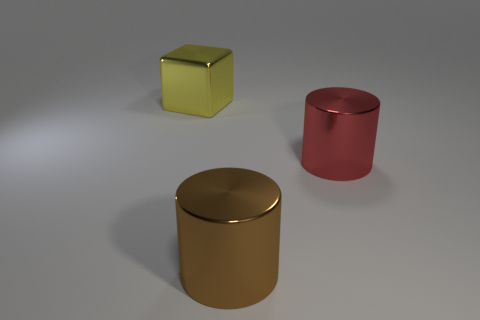

In [29]:
import PIL.Image
image_file = "c342fa9eff27feed14776bcb554ce9b1.png"
image_dir = "/home/jnlp/minhnt/AdvML/custom_dataset/train"
image = PIL.Image.open(f"{image_dir}/{image_file}").convert("RGB")
image.show()

In [34]:
# train dev split

import pandas as pd
from sklearn.model_selection import train_test_split

train_labels_path = "/home/jnlp/minhnt/AdvML/custom_dataset/train_labels.csv"

train_data = pd.read_csv(train_labels_path)

train_df, dev_df = train_test_split(train_data, test_size=0.1, random_state=42)

print(f"Train size: {len(train_df)}, Dev size: {len(dev_df)}")

train_split_path = "/home/jnlp/minhnt/AdvML/custom_dataset/train_split.csv"
dev_split_path = "/home/jnlp/minhnt/AdvML/custom_dataset/dev_split.csv"
train_df.to_csv(train_split_path, index=False)
dev_df.to_csv(dev_split_path, index=False)

Train size: 4500, Dev size: 500


In [3]:
import pandas as pd

train_labels_path = "/home/jnlp/minhnt/AdvML/custom_dataset/train_labels.csv"

train_data = pd.read_csv(train_labels_path)

display(train_data.head())

,id,file,question,answer,explanation
0,0,fe5788c604751c347b0ba8f2f3566ad3.png,Are there an equal number of cubes behind the ...,yes,['There is a cube which is behind the tiny gra...
1,1,440229924eabdfecfd6b5ea8924f110c.png,There is a tiny red thing that is right of the...,no,['There are no tiny red balls which are on the...
2,2,0fbc2f311764ee128cd7379ef782f6c6.png,There is a block in front of the cube that is ...,large,['There is a big block which is in front of th...
3,3,24365d41930e8f5356e00dce95c023a2.png,Are there any other things that have the same ...,yes,['There is a brown cylinder which has the iden...
4,4,41f522189bbba92decc439baa9c292e0.png,Is there anything else that has the same shape...,no,['There are no things which have the identical...


In [42]:
train_split_path = "/home/jnlp/minhnt/AdvML/custom_dataset/train_split.csv"
dev_split_path = "/home/jnlp/minhnt/AdvML/custom_dataset/dev_split.csv"

train_df = pd.read_csv(train_split_path)
dev_df = pd.read_csv(dev_split_path)

train_answers = set(train_df['answer'].tolist())
dev_answers = set(dev_df['answer'].tolist())

# uncommon answers between train and dev
uncommon_answers = dev_answers - train_answers
print(f"Number of uncommon answers between train and dev: {len(uncommon_answers)}")
print(uncommon_answers)

print(dev_answers)
print(train_answers)

Number of uncommon answers between train and dev: 0
set()
{'3', 'yes', 'sphere', '0', 'large', 'brown', 'no', 'blue', 'cube', 'metal', 'green', 'gray', 'red', 'cyan', '1', 'rubber', 'cylinder', '5', 'purple', 'yellow', 'small', '2'}
{'3', 'yes', '6', 'sphere', '0', 'large', 'brown', 'no', '4', 'blue', 'cube', 'metal', 'green', '8', 'gray', '9', 'red', 'cyan', '1', 'rubber', 'cylinder', '5', 'purple', 'yellow', '7', '2', 'small'}


In [31]:
answers = train_data['answer']
# statistics of answer length
answer_lengths = answers.apply(lambda x: len(str(x).split()))
print("Answer length statistics:")
print(f"Max length: {answer_lengths.max()}")
print(f"Min length: {answer_lengths.min()}")
print(f"Mean length: {answer_lengths.mean()}")

# print unique answers and their counts
print("Unique answers:", answers.unique())
print("Answer counts:")
print(answers.value_counts())

Answer length statistics:
Max length: 1
Min length: 1
Mean length: 1.0
Unique answers: ['yes' 'no' 'large' 'red' 'metal' 'sphere' 'gray' '0' 'rubber' '2' 'small'
 'purple' '1' 'cylinder' '6' 'cyan' 'yellow' 'cube' 'blue' '3' '4' 'brown'
 '5' 'green' '7' '8' '9']
Answer counts:
answer
no          1254
yes          929
1            343
0            286
small        257
large        256
metal        246
rubber       244
2            184
sphere       164
cylinder     149
cube         140
3            103
brown         59
gray          49
cyan          48
yellow        45
blue          44
red           42
purple        39
4             37
green         34
5             28
6             11
7              6
8              2
9              1
Name: count, dtype: int64


In [37]:
# compare dev test questions
import pandas as pd
dev_data = pd.read_csv("/home/jnlp/minhnt/AdvML/custom_dataset/dev_split.csv")
test_data = pd.read_csv("/home/jnlp/minhnt/AdvML/custom_dataset/test.csv")

common_questions = set(dev_data['question']).intersection(set(test_data['question']))
print(f"Number of common questions between dev and test: {len(common_questions)}")
for q in list(common_questions)[:10]:
    print(q)
    
print(dev_data['question'][0])
print(test_data['question'][0])
print(test_data['question'][1])
print(test_data['question'][2])

# count length of questions
dev_question_lengths = dev_data['question'].apply(lambda x: len(str(x).split()))
test_question_lengths = test_data['question'].apply(lambda x: len(str(x).split()))
print("Dev question length statistics:")
print(f"Max length: {dev_question_lengths.max()}")
print(f"Min length: {dev_question_lengths.min()}")
print(f"Mean length: {dev_question_lengths.mean()}")
print("Test question length statistics:")
print(f"Max length: {test_question_lengths.max()}")
print(f"Min length: {test_question_lengths.min()}")
print(f"Mean length: {test_question_lengths.mean()}")
    
# # extract vocabulary from questions
# dev_vocab = set()
# test_vocab = set()
# for question in dev_data['question']:
#     words = question.lower().split()
#     dev_vocab.update(words)
# for question in test_data['question']:
#     words = question.lower().split()
#     test_vocab.update(words)

# print(f"Dev vocab size: {len(dev_vocab)}")
# print(f"Dev vocab sample: {list(dev_vocab)[:10]}")

# print(f"Test vocab size: {len(test_vocab)}")
# print(f"Test vocab sample: {list(test_vocab)[:10]}")

# # word frequency in dev questions
# from collections import Counter
# dev_word_counter = Counter()
# for question in dev_data['question']:
#     words = question.lower().split()
#     dev_word_counter.update(words)
    
# print("Top 10 most common words in dev questions:")
# for word, count in dev_word_counter.most_common(20):
#     print(f"{word}: {count}")

Number of common questions between dev and test: 1
Are there any other things that are the same shape as the gray shiny object?
What is the size of the sphere that is the same material as the small cylinder?
What material is the yellow cylinder that is to the right of the tiny rubber object in front of the red metal block made of?
Are there any other things that have the same shape as the small red object?
There is a big block that is to the left of the metallic thing in front of the metal thing behind the brown object; what is its material?
Dev question length statistics:
Max length: 36
Min length: 5
Mean length: 18.044
Test question length statistics:
Max length: 34
Min length: 6
Mean length: 17.878


<class 'str'>
The rubber cube is gray.
Example explaination: The rubber cube is gray.
Explaination length statistics:
Max length: 45
Min length: 4
Mean length: 17.771455369704547


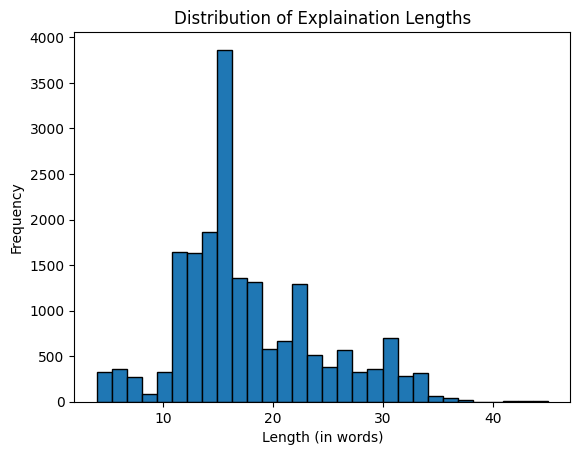

In [8]:
import ast
import pandas as pd

train_split_path = "/home/jnlp/minhnt/AdvML/custom_dataset/train_split.csv"
train_data = pd.read_csv(train_split_path)

print(type(train_data['explanation'][0]))
# convert strong to list
print(ast.literal_eval(train_data['explanation'][0])[0])

exs = []
for explaination in train_data['explanation']:
    explaination_list = ast.literal_eval(explaination)
    for x in explaination_list:
        exs.append(x)
    # exs.append(explaination_list[0])
    
print("Example explaination:", exs[0])
# statistics of explaination length
explaination_lengths = [len(ex.split()) for ex in exs]
print("Explaination length statistics:")
print(f"Max length: {max(explaination_lengths)}")
print(f"Min length: {min(explaination_lengths)}")
print(f"Mean length: {sum(explaination_lengths)/len(explaination_lengths)}")

import matplotlib.pyplot as plt
plt.hist(explaination_lengths, bins=30, edgecolor='black')
plt.title('Distribution of Explaination Lengths')
plt.xlabel('Length (in words)')
plt.ylabel('Frequency')
plt.show()

  answer  count      mean  median  min  max      std   q25   q75
      no   1144 16.986888    14.0    5   36 6.440304 13.00 21.00
     yes    839 18.849821    18.0    4   37 6.390726 14.00 23.00
       1    310 13.609677    14.0    4   34 6.249342 11.00 16.00
       0    267 13.292135    14.0    4   33 6.915498  6.00 16.00
   large    228 16.372807    16.0    5   35 6.040725 14.00 18.00
   small    225 16.942222    16.0    5   32 5.865398 14.00 20.00
   metal    222 17.054054    16.0    5   35 6.758722 14.00 20.00
  rubber    218 16.949541    16.0    5   34 6.098442 14.00 19.75
       2    150 15.086667    14.0    4   34 7.077649 11.00 19.00
  sphere    144 16.159722    15.0    5   33 5.925721 13.00 18.00
cylinder    135 15.851852    15.0    5   31 4.970838 14.00 17.00
    cube    123 15.601626    16.0    6   33 5.217781 13.00 17.00
       3     89 17.865169    18.0    4   34 7.227144 14.00 22.00
   brown     53 15.981132    16.0    4   32 7.492280 11.00 21.00
    cyan     45 16.511111

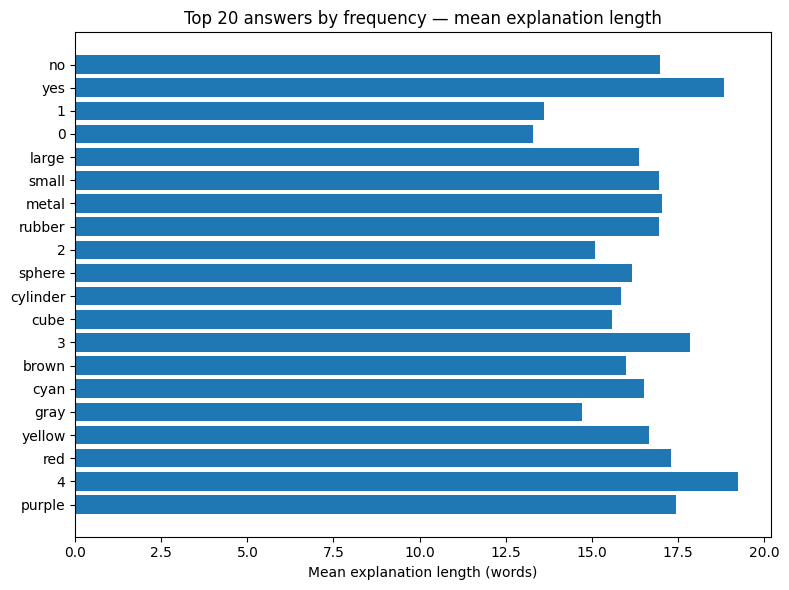

In [3]:
# ...existing code...
# answer length distribution by answer
import pandas as pd
import ast
import numpy as np

# adjust path if you want to run on dev/test/train splits
csv_path = "/home/jnlp/minhnt/AdvML/custom_dataset/train_split.csv"
out_csv = "/home/jnlp/minhnt/AdvML/results/explanation_length_by_answer.csv"

df = pd.read_csv(csv_path)

def first_explanation_text(s):
    try:
        lst = ast.literal_eval(s)
        if isinstance(lst, (list, tuple)) and len(lst) > 0:
            return str(lst[0])
        return str(s)
    except Exception:
        return str(s)

df['explanation_text'] = df['explanation'].apply(first_explanation_text)
df['explanation_len'] = df['explanation_text'].apply(lambda x: len(str(x).split()))

# aggregate stats by answer
grouped = df.groupby('answer')['explanation_len'].agg(['count', 'mean', 'median', 'min', 'max', 'std']).reset_index()
percentiles = df.groupby('answer')['explanation_len'].quantile([0.25, 0.75]).unstack(level=1).reset_index().rename(columns={0.25: 'q25', 0.75: 'q75'})
report = grouped.merge(percentiles, on='answer')
report = report.sort_values('count', ascending=False)

# display and save
print(report.to_string(index=False))
# report.to_csv(out_csv, index=False)

# Optional quick plot (uncomment)
import matplotlib.pyplot as plt
top = report.sort_values('count', ascending=False).head(20)
plt.figure(figsize=(8,6))
plt.barh(top['answer'].astype(str), top['mean'])
plt.xlabel('Mean explanation length (words)')
plt.title('Top 20 answers by frequency — mean explanation length')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
# ...existing code...

In [15]:
# build explanation vocab
import ast
import pandas as pd
train_split_path = "/home/jnlp/minhnt/AdvML/custom_dataset/train_split.csv"
train_data = pd.read_csv(train_split_path)
explanation_vocab = set()
for explaination in train_data['explanation']:
    explaination_list = ast.literal_eval(explaination)
    for x in explaination_list:
        x = x.split()
        explanation_vocab.update(x)
        
print(f"Explanation vocab size: {len(explanation_vocab)}")
print(f"Sample vocab words: {list(explanation_vocab)[:10]}")

Explanation vocab size: 105
Sample vocab words: ['shiny', 'things.', 'spheres', 'no', 'big', 'cylinders,', 'blocks', 'has', 'there', 'gray.']


In [20]:
dev_res_path="/home/jnlp/minhnt/AdvML/results/dev_gen_x/internvl2_5_4b_sft_genx_with_answers.csv"
dev_data = pd.read_csv(dev_res_path)

dev_x_vocab = set()
for explaination in dev_data['explanation']:
    dev_x_vocab.update(str(explaination).split())
print(f"Dev explanation vocab size: {len(dev_x_vocab)}")
print(f"Sample dev vocab words: {list(dev_x_vocab)[:10]}")

for explaination in dev_data['explanation'][:10]:
    print("Original explaination:", explaination)
    words = str(explaination).split()
    new_x = ""
    for w in words:
        if w in explanation_vocab:
            new_x += w + " "
    
    print("Filtered explaination:", new_x.strip())
    # break
    

Dev explanation vocab size: 126
Sample dev vocab words: ['shiny', 'things.', 'spheres', 'no', 'at', 'big', 'made', 'blocks', 'gold', 'has']
Original explaination: There is a small purple metallic sphere that has the same material as a small cylinder.
Filtered explaination: There is a small purple metallic sphere that has the same material as a small cylinder.
Original explaination: There is a big red sphere and there is a big brown rubber cylinder that is right of the metallic ball.
Filtered explaination: There is a big red sphere and there is a big brown rubber cylinder that is right of the metallic ball.
Original explaination: There is a green block.
Filtered explaination: There is a green block.
Original explaination: There are no things that have the same shape as a small cyan sphere.
Filtered explaination: There are no things that have the same shape as a small cyan sphere.
Original explaination: There is a large brown cylinder which has the identical shape as a big red metallic c

In [13]:
# split image folder 

import pandas as pd
import os

train_split_data = pd.read_csv("/home/jnlp/minhnt/AdvML/custom_dataset/train_split.csv")
dev_split_data = pd.read_csv("/home/jnlp/minhnt/AdvML/custom_dataset/dev_split.csv")

image_dir = "/home/jnlp/minhnt/AdvML/custom_dataset/train"
train_split_img_dir = "/home/jnlp/minhnt/AdvML/custom_dataset/train_split_img"
dev_split_img_dir = "/home/jnlp/minhnt/AdvML/custom_dataset/dev_split_img"

for img_file in train_split_data['file']:
    src_path = os.path.join(image_dir, img_file)
    dst_path = os.path.join(train_split_img_dir, img_file)
    os.system(f"cp {src_path} {dst_path}")
    
for img_file in dev_split_data['file']:
    src_path = os.path.join(image_dir, img_file)
    dst_path = os.path.join(dev_split_img_dir, img_file)
    os.system(f"cp {src_path} {dst_path}")

In [21]:
import os
from torch import range

dev_img_paths = os.listdir("/home/jnlp/minhnt/AdvML/custom_dataset/dev_split_img")

print(len(dev_img_paths))
print(dev_img_paths[:10])

tmp_paths = []
for i, fn in enumerate(dev_img_paths):
    idx = (os.path.splitext(fn)[0].split('_')[-1])
    print(idx)
    print(i)
    break

500
['6708520884e28f9e5a641e52b54227a7.png', '07415039f24f4f6402f979c102ae8678.png', '2adbbb3d8444ae4b68d00db1dd388cad.png', 'd396a432a18536cfe4129e5d06d162ea.png', 'c342fa9eff27feed14776bcb554ce9b1.png', '76e77e7494cd240227672cdf5c7a3c64.png', '412ca469c15008aecfa9462b4782411b.png', '96403b80e7c416ce8c0fbd7f464449e7.png', 'ff4949f1df675acadd41d2932f489e90.png', '63daac705cb3a2ee687fead512274520.png']
6708520884e28f9e5a641e52b54227a7
0


In [45]:
# test get similar dev question type
import json
import pandas as pd
test_qtype_path = "/home/jnlp/minhnt/AdvML/custom_dataset/test_question_type.jsonl"
with open(test_qtype_path, 'r') as f:
    test_qtype_data = [json.loads(line) for line in f]
    
dev_qtype_path = "/home/jnlp/minhnt/AdvML/custom_dataset/dev_question_type.jsonl"
with open(dev_qtype_path, 'r') as f:
    dev_qtype_data = [json.loads(line) for line in f]
    
res = []
for test_sample in test_qtype_data:
    test_qtype = test_sample['question_type']
    for dev_sample in dev_qtype_data:
        dev_qtype = dev_sample['question_type']
        if test_qtype == dev_qtype:
            test_sample['similar_dev_id'] = dev_sample['id']
            test_sample['similar_dev_file'] = dev_sample['file']
            test_sample['similar_dev_question'] = dev_sample['question']
            test_sample['similar_dev_answer'] = dev_sample['answer']
            test_sample['similar_dev_explanation'] = dev_sample['explanation']
            res.append(test_sample)
            break
        
df_res = pd.DataFrame(res)
df_res.to_csv("/home/jnlp/minhnt/AdvML/custom_dataset/test_similar_dev_question.csv", index=False)
print(df_res)

      id                                  file  \
0      0  cae1e431d2cab3622a5a8836776f7fed.png   
1      1  8a5f6ad1cdf68137a64ceee6184df32c.png   
2      2  7b41bddb622a585d8076b57a1f068ba0.png   
3      3  c89e052078fe27f843af0d1c81415c79.png   
4      4  af4b3377a892344f76334b4cbb7051c4.png   
..   ...                                   ...   
493  495  867869454b8dc8481090c4b88fcae3d9.png   
494  496  ebe395d238476796b5c93ee910e9c9ac.png   
495  497  950d2e003664f85b92eb74e5f9881f7f.png   
496  498  f45df59cd62ec95b441072805c63af58.png   
497  499  cfb8e72e97b6cefaceff37d069c61f90.png   

                                              question question_type  \
0    What material is the yellow cylinder that is t...      material   
1    Are there any other things that have the same ...         shape   
2    There is a big block that is to the left of th...      material   
3    Is the number of big purple objects greater th...         count   
4    What shape is the small brown obje

In [1]:
import pandas as pd

test_tbd_data = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test/tbd_nets.csv")
qwen_test_data = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test/qwen2_5_vl_3b_internvl_2b_4b_lora_test_major_vote.csv")

test_tbd_data['explanation'] = qwen_test_data['explanation']

test_tbd_data.to_csv("/home/jnlp/minhnt/AdvML/results/test/tbd_nets_with_explanation.csv", index=False)

In [19]:
# clean explanation in test submission

import pandas as pd

def clean_explanation(df):
    df['explanation'] = df['explanation'].apply(lambda text: text.split("Explanation:")[-1].strip() if "Explanation:" in text else text.strip())
    return df

path = "/home/jnlp/minhnt/AdvML/results/test/qwen2_5_vl_3b_lora_test_hf_run2.csv"
df = pd.read_csv(path)
df = clean_explanation(df)
df.to_csv(path.replace(".csv", "_cleaned.csv"), index=False)

In [27]:
# merge test submission explanation

tbd_path = "/home/jnlp/minhnt/AdvML/results/test/tbd_nets.csv"
tbd_df = pd.read_csv(tbd_path)

df1_path = "/home/jnlp/minhnt/AdvML/results/test/internvl2_5_2b_dynamic_res_2nd_finetune_lora_test_wo_x_cleaned.csv"
df1 = pd.read_csv(df1_path)

df2_path = "/home/jnlp/minhnt/AdvML/results/test/internvl2_5_4b_dynamic_res_2nd_finetune_lora_test_wo_x_cleaned.csv"
df2 = pd.read_csv(df2_path)

# df3_path = "/home/jnlp/minhnt/AdvML/results/test/qwen2_5_vl_3b_lora_test_output_hf.csv"
# df3 = pd.read_csv(df3_path)

# df4_path = "/home/jnlp/minhnt/AdvML/results/test/qwen2_5_vl_3b_lora_test_hf_run1_cleaned.csv"
# df4 = pd.read_csv(df4_path)

# df5_path = "/home/jnlp/minhnt/AdvML/results/test/qwen2_5_vl_3b_lora_test_hf_run2_cleaned.csv"
# df5 = pd.read_csv(df5_path)

merged_explanations = []
for i in range(len(tbd_df)):
    if len(df1['explanation'][i].split()) < 4:
        explanations = df2['explanation'][i]
    elif len(df2['explanation'][i].split()) < 4:
        explanations = df1['explanation'][i]
    else:
        explanations = df2['explanation'][i]
    merged_explanations.append(explanations)
    
tbd_df['explanation'] = merged_explanations
tbd_df.to_csv("/home/jnlp/minhnt/AdvML/results/test/tbd_nets_merged_explanations_b4_ans_gt.csv", index=False)

In [23]:
# merge dev explanation

df1 = pd.read_csv("/home/jnlp/minhnt/AdvML/results/dev_gen_x/internvl2_5_4b_sft_genx_with_answers.csv")
df2 = pd.read_csv("/home/jnlp/minhnt/AdvML/results/dev_gen_x/qwen25-vl-3b-instruct-trl-sft_genx_with_answers.csv")

explanations = []
for i in range(len(df1)):
    explanations.append([df1.loc[i, 'explanation'], df2.loc[i, 'explanation']])

df1['explanation'] = explanations
df1.to_csv("/home/jnlp/minhnt/AdvML/results/dev_gen_x/internvl2_5_4b_qwen2_5_vl_3b_genx_with_answers.csv", index=False)    

In [6]:
# build explanation vocab
import ast
import pandas as pd
train_split_path = "/home/jnlp/minhnt/AdvML/custom_dataset/train_labels.csv"
train_data = pd.read_csv(train_split_path)
explanation_vocab = set()
for explaination in train_data['explanation']:
    explaination_list = ast.literal_eval(explaination)
    for x in explaination_list:
        x = x.split()
        explanation_vocab.update(x)
        
print(f"Explanation vocab size: {len(explanation_vocab)}")
print(f"Sample vocab words: {list(explanation_vocab)[:10]}")

def check_explanation_vocab(explanation, train_x_vocab):
    words = str(explanation).split()
    if any(w not in train_x_vocab for w in words):
        return False
    return True

Explanation vocab size: 105
Sample vocab words: ['right', 'balls.', 'things.', 'front', 'two', 'big', 'spheres.', 'blocks.', 'metal.', 'color']


In [9]:
test_df = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test_gen_x/internvl2_5_4b_sft_11k_genx_merged_shorter_explanations_with_answers.csv")
for explanation in test_df['explanation']:
    is_in_vocab = check_explanation_vocab(explanation, explanation_vocab)
    if not is_in_vocab:
        print(f"Explanation: {explanation}")
        print(f"All words in train vocab: {is_in_vocab}")

In [ ]:
# merge test explanation by train explanation vocab
df1 = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test_gen_x/internvl2_5_4b_sft_11k_genx_v1_with_answers.csv")
df2 = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test_gen_x/internvl2_5_4b_sft_11k_genx_v2_with_answers.csv")
df3 = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test_gen_x/internvl2_5_4b_sft_11k_genx_v3_with_answers.csv")

def check_explanation_vocab(explanation, train_x_vocab):
    words = str(explanation).split()
    if any(w not in train_x_vocab for w in words):
        return False
    return True

for i in range(len(df1)):
    ex1 = df1.loc[i, 'explanation']
    ex2 = df2.loc[i, 'explanation']
    ex3 = df3.loc[i, 'explanation']
    valid_ex1 = check_explanation_vocab(ex1, explanation_vocab)
    valid_ex2 = check_explanation_vocab(ex2, explanation_vocab)
    valid_ex3 = check_explanation_vocab(ex3, explanation_vocab)
    
    if valid_ex1 and not valid_ex2:
        df1.loc[i, 'explanation'] = ex1
    elif not valid_ex1 and valid_ex2:
        df1.loc[i, 'explanation'] = ex2
    elif valid_ex1 and valid_ex2: # both are valid, choose shorter # then longer
        len1 = len(str(ex1).split())
        len2 = len(str(ex2).split())
        if len2 > len1:
            df1.loc[i, 'explanation'] = ex2
        # df1.loc[i, 'explanation'] = ex1
    else:
        print(f"Both explanations invalid at index {i}")
        len1 = len(str(ex1).split())
        len2 = len(str(ex2).split())
        if len2 > len1:
            df1.loc[i, 'explanation'] = ex2.split('.')[0].strip()
        else:
            df1.loc[i, 'explanation'] = ex1.split('.')[0].strip()
        
df1.to_csv("/home/jnlp/minhnt/AdvML/results/test_gen_x/internvl2_5_4b_sft_11k_genx_merged_longer_explanations_with_answers.csv", index=False)

Both explanations invalid at index 56
Both explanations invalid at index 59
Both explanations invalid at index 76
Both explanations invalid at index 134
Both explanations invalid at index 232
Both explanations invalid at index 244
Both explanations invalid at index 300
Both explanations invalid at index 306
Both explanations invalid at index 326
Both explanations invalid at index 372
Both explanations invalid at index 402
Both explanations invalid at index 488


In [ ]:
# merge test explanation by train explanation vocab
df1 = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test_gen_x/internvl2_5_4b_sft_11k_genx_v1_with_answers.csv")
df2 = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test_gen_x/internvl2_5_4b_sft_11k_genx_v2_with_answers.csv")
df3 = pd.read_csv("/home/jnlp/minhnt/AdvML/results/test_gen_x/internvl2_5_4b_sft_11k_genx_v3_with_answers.csv")

def check_explanation_vocab(explanation, train_x_vocab):
    words = str(explanation).split()
    if any(w not in train_x_vocab for w in words):
        return False
    return True

for i in range(len(df1)):
    ex1 = df1.loc[i, 'explanation']
    ex2 = df2.loc[i, 'explanation']
    ex3 = df3.loc[i, 'explanation']
    # valid_ex1 = check_explanation_vocab(ex1, explanation_vocab)
    # valid_ex2 = check_explanation_vocab(ex2, explanation_vocab)
    # valid_ex3 = check_explanation_vocab(ex3, explanation_vocab)
    
    len1 = len(str(ex1).split())
    len2 = len(str(ex2).split())
    len3 = len(str(ex3).split())
    
    # choose the shortest valid explanation
    lens = [len1, len2, len3]
    min_len_idx = lens.index(min(lens))
    shortest_ex = [ex1, ex2, ex3][min_len_idx]
    
    if not check_explanation_vocab(shortest_ex, explanation_vocab):
        # if shortest is not valid, choose the next shortest
        shortest_ex = shortest_ex.split('.')[0].strip()
        
    df1.loc[i, 'explanation'] = shortest_ex
    
    # if valid_ex1 and not valid_ex2:
    #     df1.loc[i, 'explanation'] = ex1
    # elif not valid_ex1 and valid_ex2:
    #     df1.loc[i, 'explanation'] = ex2
    # elif valid_ex1 and valid_ex2: # both are valid, choose shorter # then longer
    #     len1 = len(str(ex1).split())
    #     len2 = len(str(ex2).split())
    #     if len2 > len1:
    #         df1.loc[i, 'explanation'] = ex2
    #     # df1.loc[i, 'explanation'] = ex1
    # else:
    #     print(f"Both explanations invalid at index {i}")
    #     len1 = len(str(ex1).split())
    #     len2 = len(str(ex2).split())
    #     if len2 > len1:
    #         df1.loc[i, 'explanation'] = ex2.split('.')[0].strip()
    #     else:
    #         df1.loc[i, 'explanation'] = ex1.split('.')[0].strip()
        
df1.to_csv("/home/jnlp/minhnt/AdvML/results/test_gen_x/internvl2_5_4b_sft_11k_genx_merged_3ver_shorter_explanations_with_answers.csv", index=False)